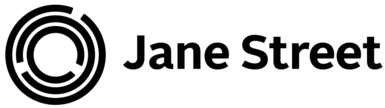

# Jane Street Market Prediction: A simple EDA

> "*Machine learning (ML) at Jane Street begins, unsurprisingly, with data. We collect and store around 2.3TB of market data every day. Hidden in those petabytes of data are the relationships and statistical regularities which inform the models inside our strategies. But it’s not just awesome models. ML work in a production environment like Jane Street’s involves many interconnected pieces.*" -- [Jane Street Tech Blog "*Real world machine learning*"](https://blog.janestreet.com/real-world-machine-learning-part-1/).

This notebook is a simple exploratory data analysis (EDA) of the files provided for the kaggle [Jane Street Market Prediction](https://www.kaggle.com/c/jane-street-market-prediction) competition. Here we shall...

> "**Explore the data:** *It’s hard to know what techniques to throw at a problem before we understand what the data looks like, and indeed figure out what data to use. Spending the time to visualize and understand the structure of the problem helps pick the right modeling tools for the job. Plus, pretty plots are catnip to traders and researchers!*"

## <center style="background-color:Gainsboro; width:40%;">Contents</center>
* [The train.csv file is big](#train_csv)
* [Cumulative return](#return)
* [Weight](#weight)
* [The features](#features)
* [The `features.csv` file](#features_file)
* [Action](#action)
* [The first day ("day 0")](#day_0)
* [Is there any missing data?](#missing)
* [DABL plots (action and resp)](#DABL)
* [Permutation Importance using the Random Forest](#permutation)
* [Is there any correlation between day 2 and day 294?](#Pearson)
* [The test data](#test_data)
* [Evaluation](#evaluation)

In [1]:
# numpy
import numpy as np

# pandas stuff
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# plotting stuff
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
colorMap = sns.light_palette("blue", as_cmap=True)

# install stuff
!pip install dabl > /dev/null
import dabl
# install datatable
!pip install datatable > /dev/null
import datatable as dt

# misc
import missingno as msno

# system
import warnings
warnings.filterwarnings('ignore')
# for the image import
import os
from IPython.display import Image
# garbage collector to keep RAM in check
import gc  

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


<a class="anchor" id="train_csv"></a>
## <center style="background-color:Gainsboro; width:40%;">The train.csv file is big</center>

The train.csv is large: 5.77G. Let us see just how many rows it has:

In [2]:
!wc -l ../input/jane-street-market-prediction/train.csv

2390492 ../input/jane-street-market-prediction/train.csv


We can see that it has a total of 2,390,492 rows. I recommend reading this magnificent [Tutorial on reading large datasets](https://www.kaggle.com/rohanrao/tutorial-on-reading-large-datasets) by [Vopani](https://www.kaggle.com/rohanrao).

I have used pandas to load in the `train.csv` and it took almost 2 minutes. To speed things up here I shall use [datatable](https://datatable.readthedocs.io/en/latest/):

In [3]:
%%time

train_data_datatable = dt.fread('../input/jane-street-market-prediction/train.csv')

CPU times: user 33.7 s, sys: 4.49 s, total: 38.2 s
Wall time: 10.3 s


and then [convert to a pandas dataframe](https://datatable.readthedocs.io/en/latest/api/frame/to_pandas.html)

In [4]:
%%time

train_data = train_data_datatable.to_pandas()

CPU times: user 6.68 s, sys: 3.87 s, total: 10.6 s
Wall time: 5.53 s


We now have loaded `train.csv` in less than 17 seconds.

<a class="anchor" id="return"></a>
## <center style="background-color:Gainsboro; width:40%;">Cumulative return</center>

There are a total of 500 days of data in `train.csv` (*i.e.* two years of trading data). Let us take a look at the cumulative return over time

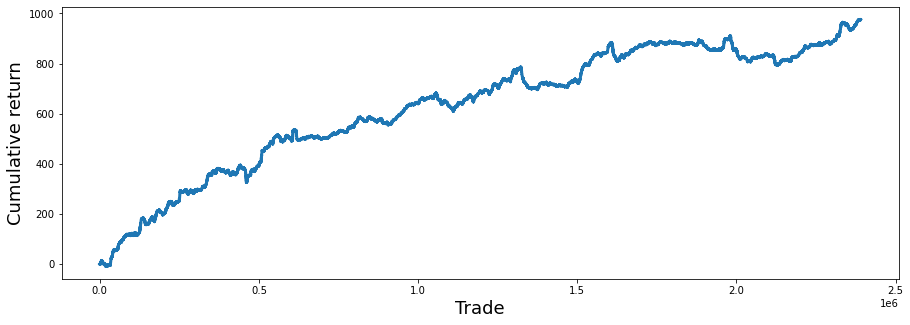

In [5]:
fig, ax = plt.subplots(figsize=(15, 5))
balance= pd.Series(train_data['resp']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_ylabel ("Cumulative return", fontsize=18);
balance.plot(lw=3);

as well as four [time horizons](https://www.investopedia.com/terms/t/timehorizon.asp)
> "*The longer the Time Horizon, the more aggressive, or riskier portfolio, an investor can build. The shorter the Time Horizon, the more conservative, or less risky, the investor may want to adopt.*"

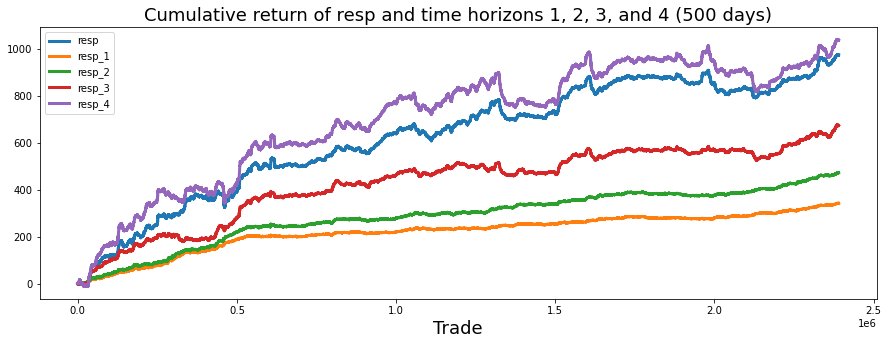

In [6]:
fig, ax = plt.subplots(figsize=(15, 5))
balance= pd.Series(train_data['resp']).cumsum()
resp_1= pd.Series(train_data['resp_1']).cumsum()
resp_2= pd.Series(train_data['resp_2']).cumsum()
resp_3= pd.Series(train_data['resp_3']).cumsum()
resp_4= pd.Series(train_data['resp_4']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative return of resp and time horizons 1, 2, 3, and 4 (500 days)", fontsize=18)
balance.plot(lw=3)
resp_1.plot(lw=3)
resp_2.plot(lw=3)
resp_3.plot(lw=3)
resp_4.plot(lw=3)
plt.legend(loc="upper left");

We can see that `resp` (in blue) most closely follows time horizon 4 (`resp_4` is the uppermost curve, in purple). 

In the notebook ["*Jane Street: time horizons and volatilities*"](https://www.kaggle.com/pcarta/jane-street-time-horizons-and-volatilities) written by [pcarta](pcarta), if I understand correctly, by using [maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) it is calculated that if the time horizon $(T_j$) for `resp_1` (*i.e.* $T_1$) is 1, then 
* $T_j($ `resp_2` $) ~\approx 1.4 ~T_1$
* $T_j($ `resp_3` $) ~\approx 3.9 ~T_1$ 
* $T_j($ `resp_4` $) ~\approx 11.1 ~T_1$

where $T_1$ could correspond to 5 trading days.

Let us now plot a histogram of all of the `resp` values (here only shown for values between -0.05 and 0.05)

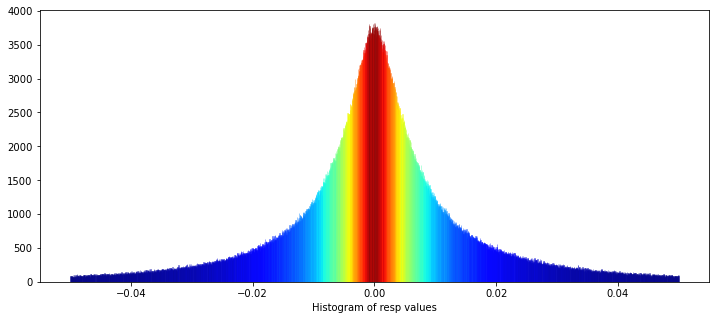

In [7]:
plt.figure(figsize = (12,5))
ax = sns.distplot(train_data['resp'], 
             bins=3000, 
             kde_kws={"clip":(-0.05,0.05)}, 
             hist_kws={"range":(-0.05,0.05)},
             color='darkcyan', 
             axlabel="Histogram of resp values",
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.show();

This distribution has very long tails

In [8]:
min_resp = train_data['resp'].min()
print('The minimum value for resp is: %.5f' % min_resp)
max_resp = train_data['resp'].max()
print('The maximum value for resp is:  %.5f' % max_resp)

The minimum value for resp is: -0.54938
The maximum value for resp is:  0.44846


Let us also calculate the [skew](https://en.wikipedia.org/wiki/Skewness) and [kurtosis](https://en.wikipedia.org/wiki/Kurtosis) of this distribution:

In [9]:
print("Skew of resp is:      %.2f" %train_data['resp'].skew() )
print("Kurtosis of resp is: %.2f"  %train_data['resp'].kurtosis() )

Skew of resp is:      0.10
Kurtosis of resp is: 17.36


<a class="anchor" id="weight"></a>
## <center style="background-color:Gainsboro; width:40%;">Weight</center>

> *Each trade has an associated `weight` and `resp`, which together represents a return on the trade.
Trades with `weight = 0` were intentionally included in the dataset for completeness, although such trades will not contribute towards the scoring evaluation.*

In [10]:
percent_zeros = (100/train_data.shape[0])*((train_data.weight.values == 0).sum())
print('Percentage of zero weights is: %i' % percent_zeros +"%")

Percentage of zero weights is: 17%


Let us see if there are any negative weights. A negative weight would be meaningless, but you never know...

In [11]:
min_weight = train_data['weight'].min()
print('The minimum weight is: %.2f' % min_weight)

The minimum weight is: 0.00


An now to find the maximum weight used

In [12]:
max_weight = train_data['weight'].max()
print('The maximum weight was: %.2f' % max_weight)

The maximum weight was: 167.29


which occured on day 446

In [13]:
train_data[train_data['weight']==train_data['weight'].max()]

date      weight    resp_1    resp_2   resp_3    resp_4      resp  \
2097681   446  167.293715  0.000281  0.001213  0.00138 -0.000427 -0.001215   

         feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
2097681         -1  -0.735754  -0.048433  -0.175366   -0.20698   0.150967   

         feature_6  feature_7  feature_8  feature_9  feature_10  feature_11  \
2097681    0.23681        NaN        NaN  -0.981118   -0.188376         NaN   

         feature_12  feature_13  feature_14  feature_15  feature_16  \
2097681         NaN   -0.361906     0.09651   -0.789638   -0.582599   

         feature_17  feature_18  feature_19  feature_20  feature_21  \
2097681         NaN         NaN   -0.455587   -0.844032         NaN   

         feature_22  feature_23  feature_24  feature_25  feature_26  \
2097681         NaN     -0.3927   -0.804331   -0.527014    -0.93592   

         feature_27  feature_28  feature_29  feature_30  feature_31  \
2097681         NaN         NaN    0.560677    1.263861         NaN   

         feature_32  feature_33  feature_34  feature_35  feature_36  \
2097681         NaN    0.581182    1.048902    0.701707    1.185705   

         feature_37  feature_38  feature_39  feature_40  feature_41  \
2097681   -0.835715   -1.292449      0.5921    1.487791    5.815692   

         feature_42  feature_43  feature_44  feature_45  feature_46  \
2097681    -1.34434   -1.418799   -1.462097   -0.046484    1.989372   

         feature_47  feature_48  feature_49  feature_50  feature_51  \
2097681    0.723026    1.331658    2.282187    5.815737    22.47588   

         feature_52  feature_53  feature_54  feature_55  feature_56  \
2097681    2.866971   -1.315372   -0.085684    1.926582    2.053201   

         feature_57  feature_58  feature_59  feature_60  feature_61  \
2097681    4.838366    6.938666    3.650405   -0.335682   -0.290041   

         feature_62  feature_63  feature_64  feature_65  feature_66  \
2097681    1.773376    1.835329    1.426806    2.693774    2.343488   

         feature_67  feature_68  feature_69  feature_70  feature_71  \
2097681    1.857384    1.828082   -0.630156    1.197453    0.135931   

         feature_72  feature_73  feature_74  feature_75  feature_76  \
2097681         NaN    0.870433         NaN    0.664872    0.833774   

         feature_77  feature_78  feature_79  feature_80  feature_81  \
2097681    1.050806         NaN    1.426755         NaN    1.748184   

         feature_82  feature_83  feature_84  feature_85  feature_86  \
2097681    1.359729     1.73875         NaN    0.983284         NaN   

         feature_87  feature_88  feature_89  feature_90  feature_91  \
2097681    0.469597    0.660712   -0.262574         NaN    2.820043   

         feature_92  feature_93  feature_94  feature_95  feature_96  \
2097681         NaN    1.342298    1.391578    0.900093         NaN   

         feature_97  feature_98  feature_99  feature_100  feature_101  \
2097681   -1.338859         NaN   -0.509267    -1.194013    -0.420336   

         feature_102  feature_103  feature_104  feature_105  feature_106  \
2097681          NaN     -0.94019          NaN    -0.237071    -1.781693   

         feature_107  feature_108  feature_109  feature_110  feature_111  \
2097681     0.616443          NaN    -0.484772          NaN    -0.253349   

         feature_112  feature_113  feature_114  feature_115  feature_116  \
2097681    -0.843852    -0.468821          NaN     0.935519          NaN   

         feature_117  feature_118  feature_119  feature_120  feature_121  \
2097681     0.828683     0.438545      0.57467     -0.92586     0.948026   

         feature_122  feature_123  feature_124  feature_125  feature_126  \
2097681    -1.094062     0.326287    -0.715126     1.490866    -1.111595   

         feature_127  feature_128  feature_129    ts_id  
2097681     1.083793    -0.979801     0.913979  2097681

Let us take a look at a histogram of the non-zero weights

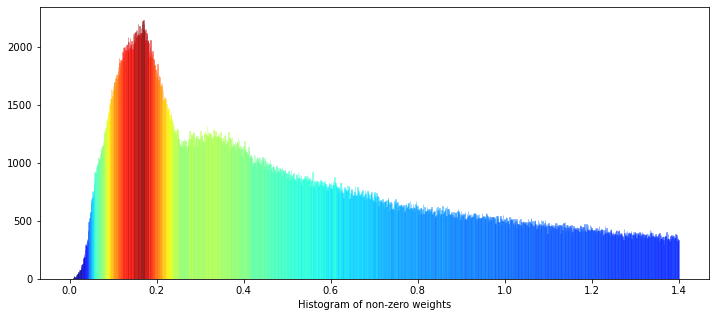

In [14]:
plt.figure(figsize = (12,5))
ax = sns.distplot(train_data['weight'], 
             bins=1400, 
             kde_kws={"clip":(0.001,1.4)}, 
             hist_kws={"range":(0.001,1.4)},
             color='darkcyan', 
             axlabel="Histogram of non-zero weights",
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.show();

There appear to be two peaks, one situated at `weight` $\approx$ 0.17, and a lower, broader peak at `weight` $\approx$ 0.34. (Could this be indicative of two underlying distributions that we see here, superimposed on each other?)

<a class="anchor" id="features"></a>
## <center style="background-color:Gainsboro; width:40%;">The features</center>

> "*This dataset contains an anonymized set of features, `feature_{0...129}`, representing real stock market data.*"

### feature_0
First of all, `feature_0` seems to be a little unusual, as it is composed solely of the integers `+1` or `-1`:

In [15]:
train_data['feature_0'].value_counts()

 1    1207005
-1    1183486
Name: feature_0, dtype: int64

Also, `feature_0` is the *only* feature in the `features.csv` file that has no `True` tags.

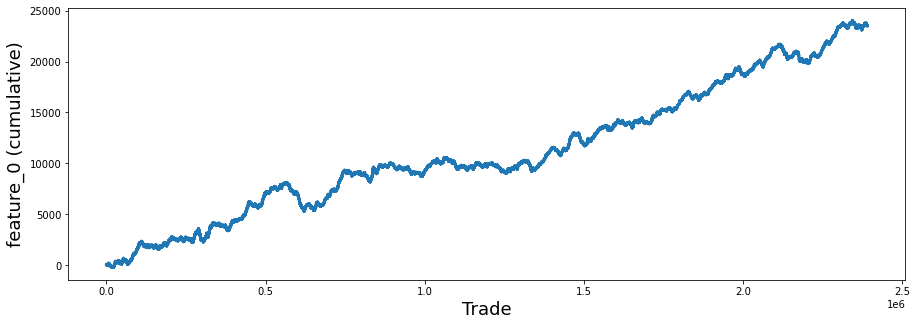

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))
feature_0 = pd.Series(train_data['feature_0']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_ylabel ("feature_0 (cumulative)", fontsize=18);
feature_0.plot(lw=3);

Any suggestions are welcome, and can be posted on the thread ["What is "feature_0" ?"](https://www.kaggle.com/c/jane-street-market-prediction/discussion/199462). 

See also this very interesting notebook ["*Feature 0, beyond feature 0*"](https://www.kaggle.com/nanomathias/feature-0-beyond-feature-0) written by [NanoMathias](https://www.kaggle.com/nanomathias), where he performs a [uniform manifold approximation and projection (UMAP)](https://arxiv.org/abs/1802.03426) and shows that `feature_0`  effectively classifies the two distributions.

### feature_{1...129}
There seem to be four general 'types' of features, here is a plot of an example of one of each:

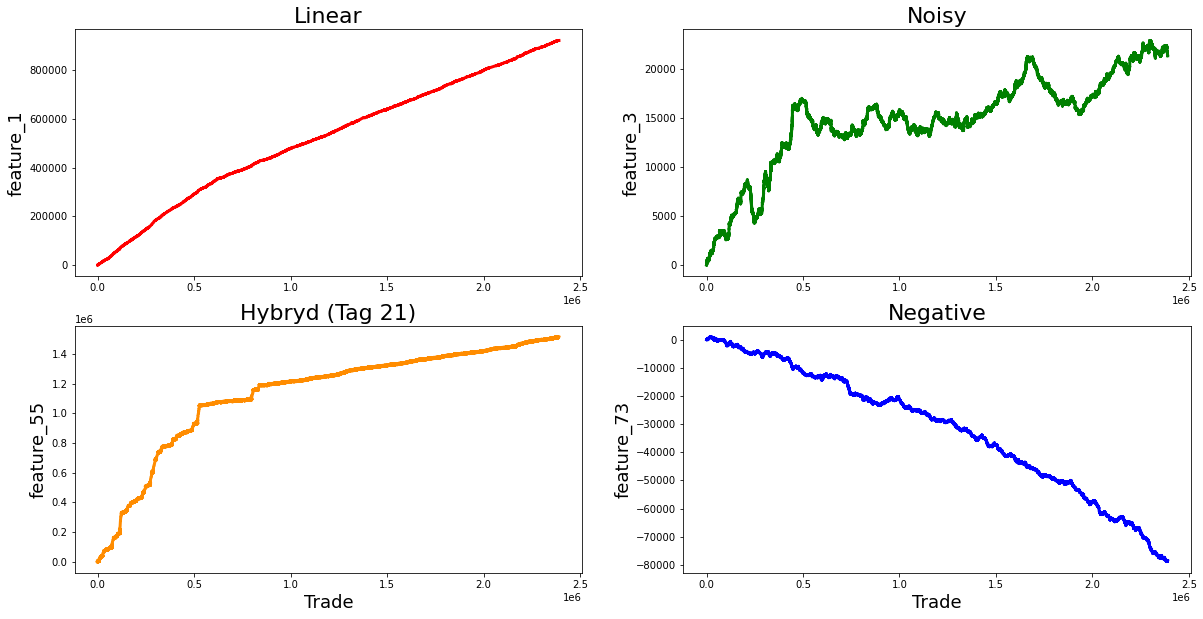

In [17]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20,10))

ax1.plot((pd.Series(train_data['feature_1']).cumsum()), lw=3, color='red')
ax1.set_title ("Linear", fontsize=22);
ax1.set_ylabel ("feature_1", fontsize=18);

ax2.plot((pd.Series(train_data['feature_3']).cumsum()), lw=3, color='green')
ax2.set_title ("Noisy", fontsize=22);
ax2.set_ylabel ("feature_3", fontsize=18);

ax3.plot((pd.Series(train_data['feature_55']).cumsum()), lw=3, color='darkorange')
ax3.set_title ("Hybryd (Tag 21)", fontsize=22);
ax3.set_xlabel ("Trade", fontsize=18)
ax3.set_ylabel ("feature_55", fontsize=18);

ax4.plot((pd.Series(train_data['feature_73']).cumsum()), lw=3, color='blue')
ax4.set_title ("Negative", fontsize=22)
ax4.set_xlabel ("Trade", fontsize=18)
ax4.set_ylabel ("feature_73", fontsize=18);

### 'Linear' features
* 1 
* 7, 9, 11, 13, 15
* 17, 19, 21, 23, 25
* 18,  20,  22,  24, 26
* 27, 29, 21, 33, 35
* 28, 30, 32, 34, 36
* 84, 85, 86, 87, 88
* 90, 91, 92, 93, 94
* 96, 97, 98, 99, 100
* 102 (strong change in gradient), 103, 104, 105, 106

as well as
41, 46, 47, 48, 49, 50, 51, 53, 54, 69, 89, 95 (strong change in gradient), 101, 107 (strong change in gradient), 108, 110, 111, 113, 114, 115, 116, 117, 118, 119 (strong change in gradient), 120, 122, and 124.


Of particular note are the **Tag 22** set:
* 60, 61, 62, 63, 64, 65, 66, 67, 68

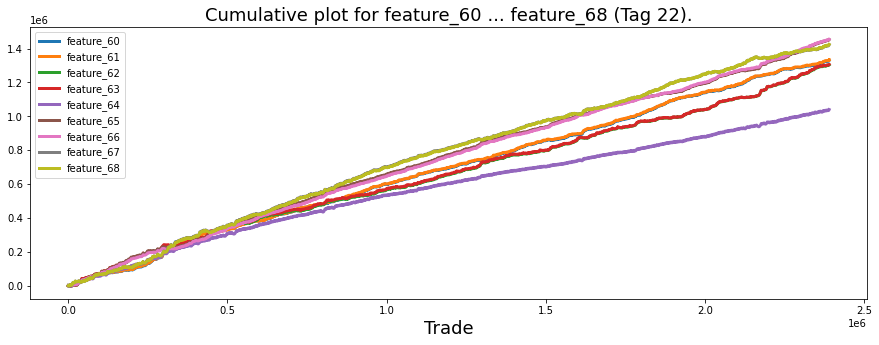

In [18]:
fig, ax = plt.subplots(figsize=(15, 5))
feature_60= pd.Series(train_data['feature_60']).cumsum()
feature_61= pd.Series(train_data['feature_61']).cumsum()
feature_62= pd.Series(train_data['feature_62']).cumsum()
feature_63= pd.Series(train_data['feature_63']).cumsum()
feature_64= pd.Series(train_data['feature_64']).cumsum()
feature_65= pd.Series(train_data['feature_65']).cumsum()
feature_66= pd.Series(train_data['feature_66']).cumsum()
feature_67= pd.Series(train_data['feature_67']).cumsum()
feature_68= pd.Series(train_data['feature_68']).cumsum()
#feature_69= pd.Series(train_data['feature_69']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative plot for feature_60 ... feature_68 (Tag 22).", fontsize=18)
feature_60.plot(lw=3)
feature_61.plot(lw=3)
feature_62.plot(lw=3)
feature_63.plot(lw=3)
feature_64.plot(lw=3)
feature_65.plot(lw=3)
feature_66.plot(lw=3)
feature_67.plot(lw=3)
feature_68.plot(lw=3)
#feature_69.plot(lw=3)
plt.legend(loc="upper left");
gc.collect();

Indeed `feature_60` and `feature_61` (both having Tags 22 & 12) are virtually coincident. 
The same goes for `feature_62` and `feature_63` (both having Tags 22 & 13), 
`feature_65` and `feature_66` (both having Tags 22 & 12) and
`feature_67` and `feature_68` (both having Tags 22 & 13).
### 'Noisy' features
* 3, 4, 5, 6 (plotted below)
* 8, 10, 12, 14, 16
* 37, 38, 39, 40
* 72, 73, 74, 75, 76
* 78, 79, 80, 81, 82
* 83

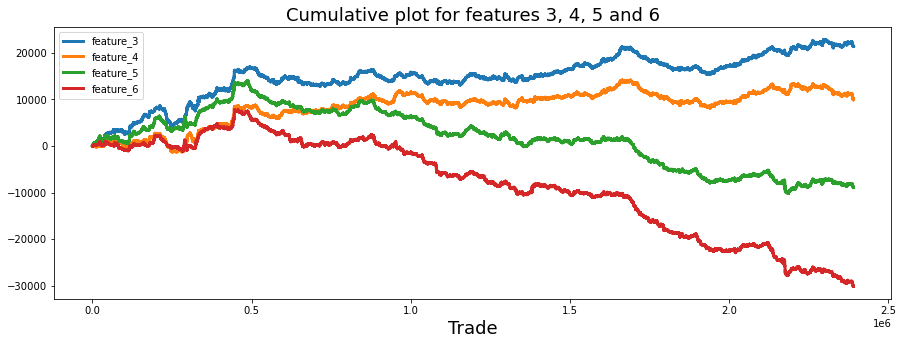

In [19]:
fig, ax = plt.subplots(figsize=(15, 5))
feature_3= pd.Series(train_data['feature_3']).cumsum()
feature_4= pd.Series(train_data['feature_4']).cumsum()
feature_5= pd.Series(train_data['feature_5']).cumsum()
feature_6= pd.Series(train_data['feature_6']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative plot for features 3, 4, 5 and 6", fontsize=18)
feature_3.plot(lw=3)
feature_4.plot(lw=3)
feature_5.plot(lw=3)
feature_6.plot(lw=3)
plt.legend(loc="upper left");
gc.collect();

### 'Negative' features
Features 73, 75, 76, 77 (noisy), 79, 81(noisy), 82. These are all found in the **Tag 23** section.

### 'Hybrid' features (Tag 21): 
55, 56, 57, 58, 59.

These start off noisy, with prominent almost discontinuous steps around the 0.2M, 0.5M, and 0.8M trade marks, then go linear. These five features form the "**Tag 21**" set:

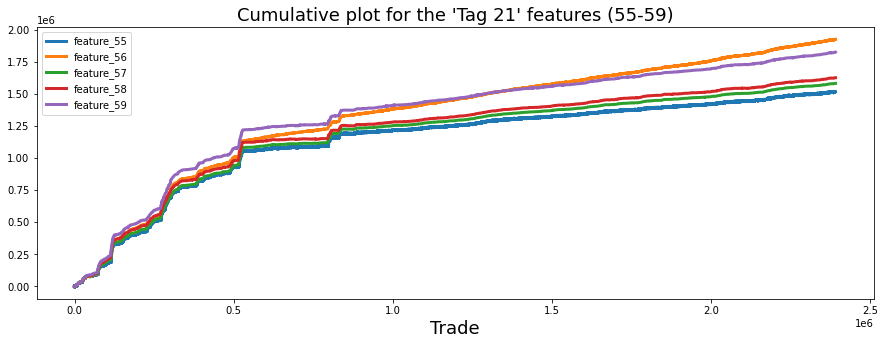

In [20]:
fig, ax = plt.subplots(figsize=(15, 5))
feature_55= pd.Series(train_data['feature_55']).cumsum()
feature_56= pd.Series(train_data['feature_56']).cumsum()
feature_57= pd.Series(train_data['feature_57']).cumsum()
feature_58= pd.Series(train_data['feature_58']).cumsum()
feature_59= pd.Series(train_data['feature_59']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative plot for the 'Tag 21' features (55-59)", fontsize=18)
feature_55.plot(lw=3)
feature_56.plot(lw=3)
feature_57.plot(lw=3)
feature_58.plot(lw=3)
feature_59.plot(lw=3)
plt.legend(loc="upper left");
gc.collect();

What if these are associated with the five `resp` values? Perhaps: 
* `feature_55` is related to `resp_1`
* `feature_56` is related to `resp_4` 
* `feature_57` is related to `resp_2` 
* `feature_58` is related to `resp_3` 
* `feature_59` is related to `resp`

If that *is* the case then 
* **Tag 0** represents `resp_4` features
* **Tag 1** represents `resp` features
* **Tag 2** represents `resp_3` features
* **Tag 3** represents `resp_2` features
* **Tag 4** represents `resp_1` features

*i.e.*
* `resp_1` related features: 7, 8, 17, 18, 27, 28, 55, 72, 78, 84, 90, 96, 102, 108, 114, 120, and 121 <font color="red">(Note: 79.6% of all of the missing data is found within this set of features).</font>
* `resp_2` related features: 11, 12, 21, 22, 31, 32, 57, 74, 80, 86, 92, 98, 104, 110, 116, 124, and 125 <font color="red">(Note: 15.2% of all of the missing data is found within this set of features).</font>
* `resp_3` related features: 13, 14, 23, 24, 33, 34, 58, 75, 81, 87, 93, 99, 105, 111, 117, 126, and 127
* `resp_4` related features: 9, 10, 19, 20, 29, 30, 56, 73, 79, 85, 91, 97, 103, 109, 115, 122, and 123
* `resp` related features: 15, 16, 25, 26, 35, 36, 59, 76, 82, 88, 94, 100, 106, 112, 118, 128, and 129

Let us take a look at a plot of each of these 17 features for each of the resp (Note: This is an image; right click to view and enlarge)

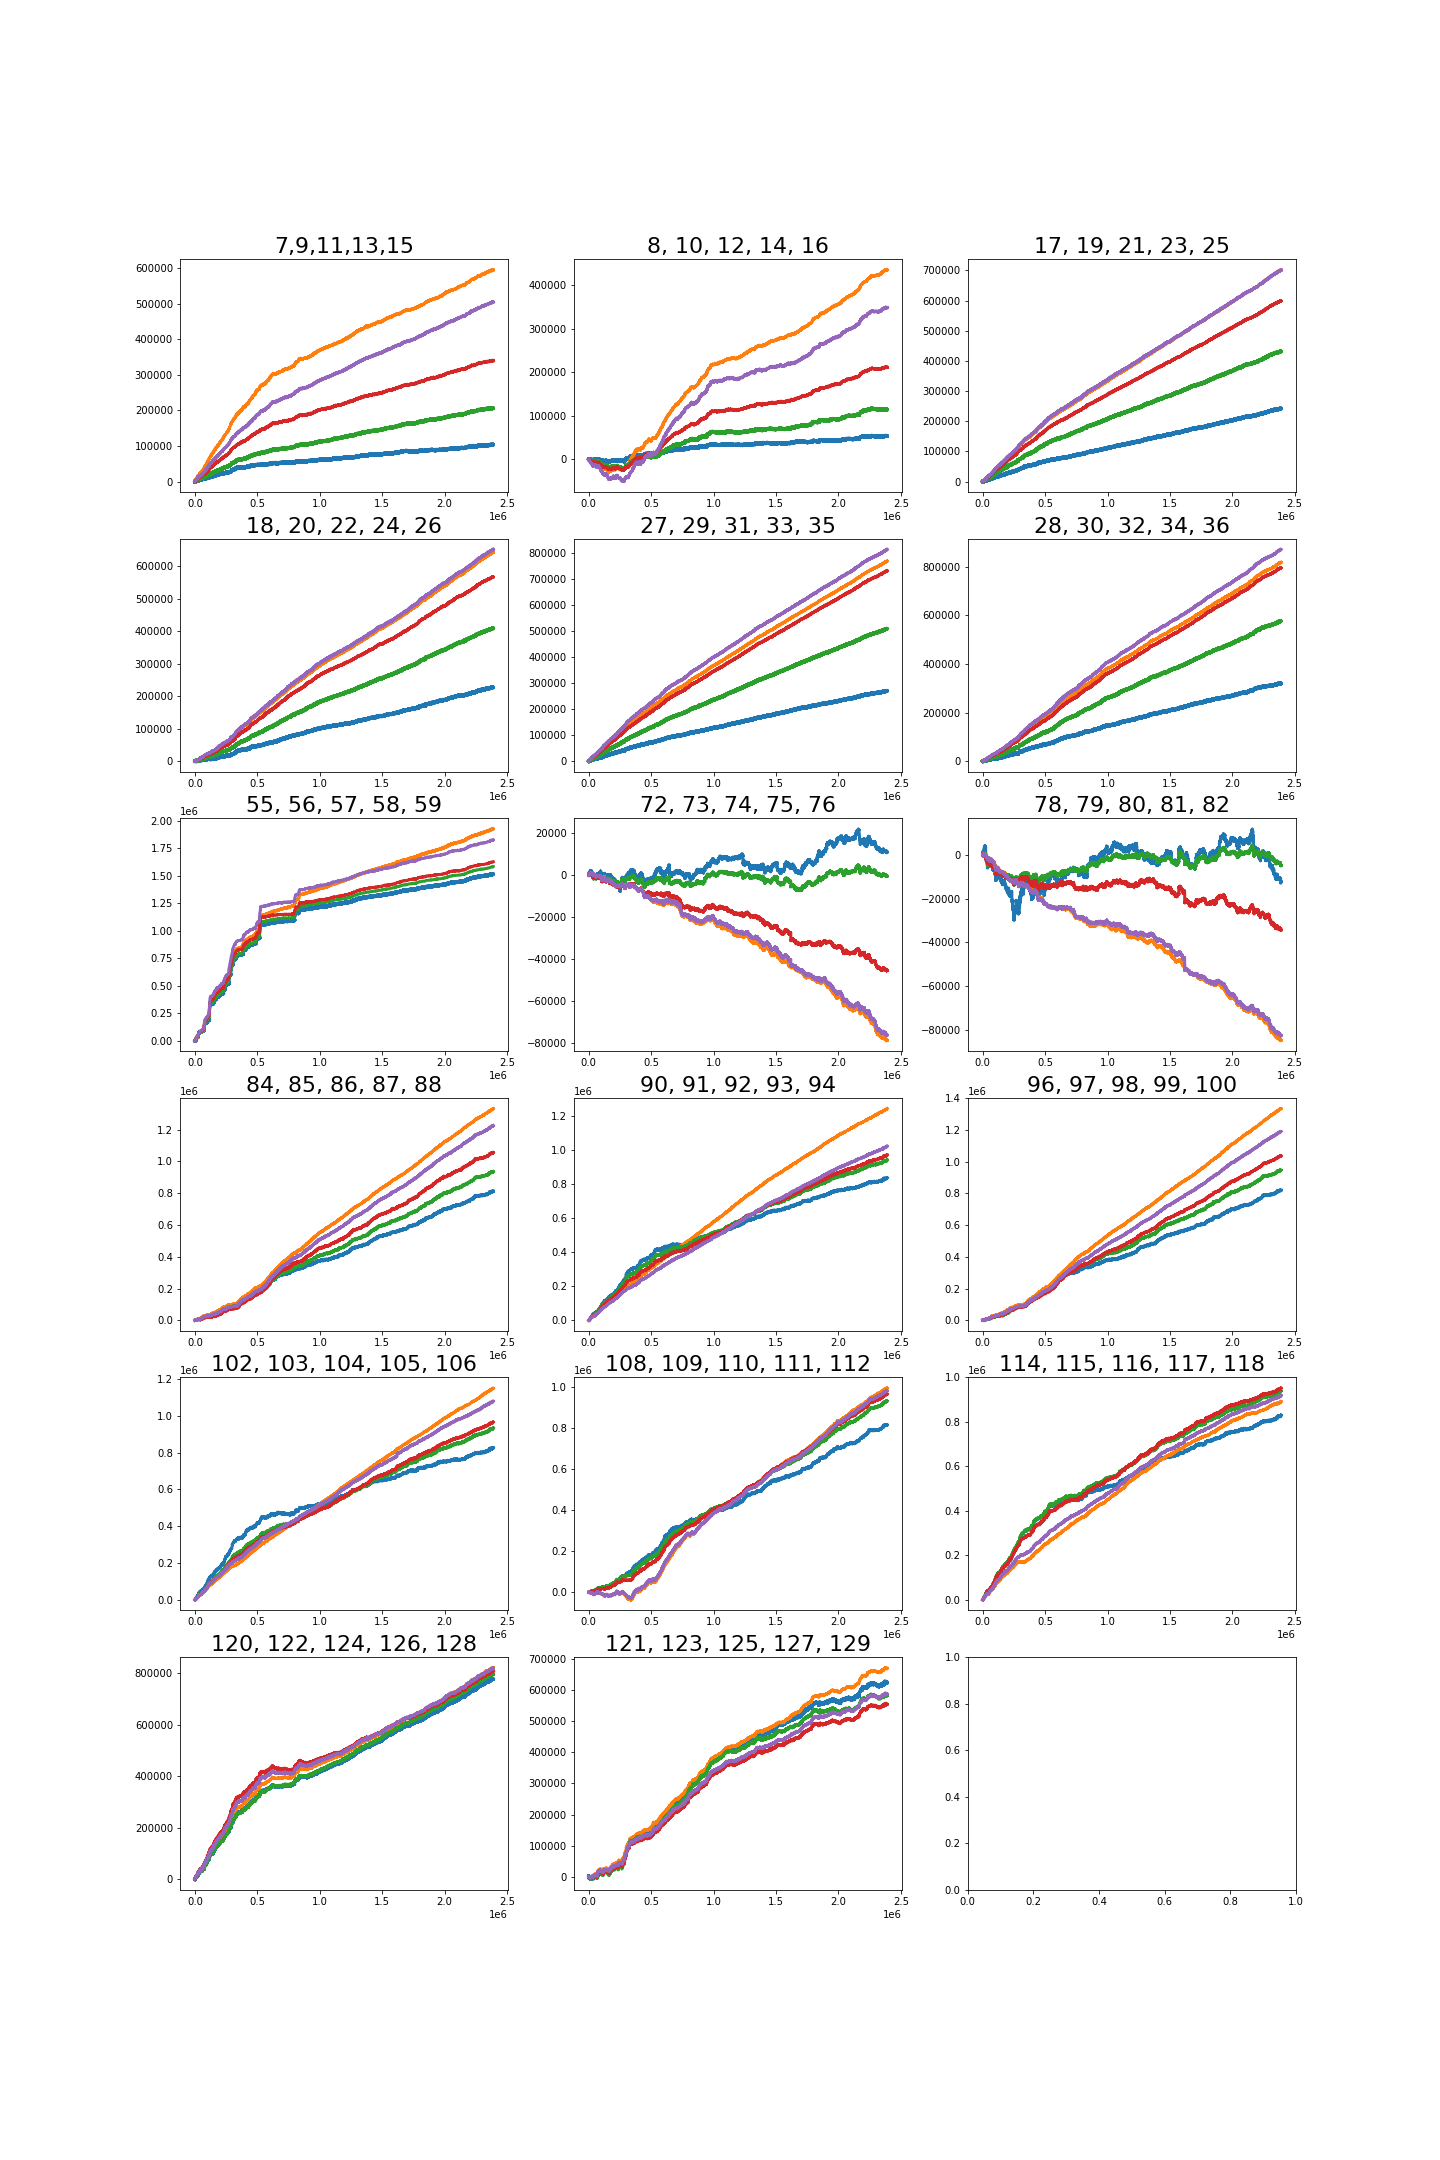

In [21]:
# Note: I have had to import this png image from another kaggle notebook 
# since producing it took up almost *all* of the notebook memory. Right click to enlarge.
Image(filename="../input/jane-17-plots/17_plots.png", width= "95%")

...which leads us to the `features.csv` file.

<a class="anchor" id="features_file"></a>
## <center style="background-color:Gainsboro; width:40%;">The features.csv file</center>

We are also provided with a `features.csv` file which contains "*metadata pertaining to the anonymized features*". Let us take a quick look at it, where `1` is `True` and `0` is `False`. The file has 29 "tags" associated with each feature.

In [22]:
feature_tags = pd.read_csv("../input/jane-street-market-prediction/features.csv" ,index_col=0)
# convert to binary
feature_tags = feature_tags*1
# plot a transposed dataframe
feature_tags.T.style.background_gradient(cmap='Oranges')

Just for fun let us re-plot the above data, but now in '8-bit' mode; totally illegible, but may perhaps serve as an overall visual aid...

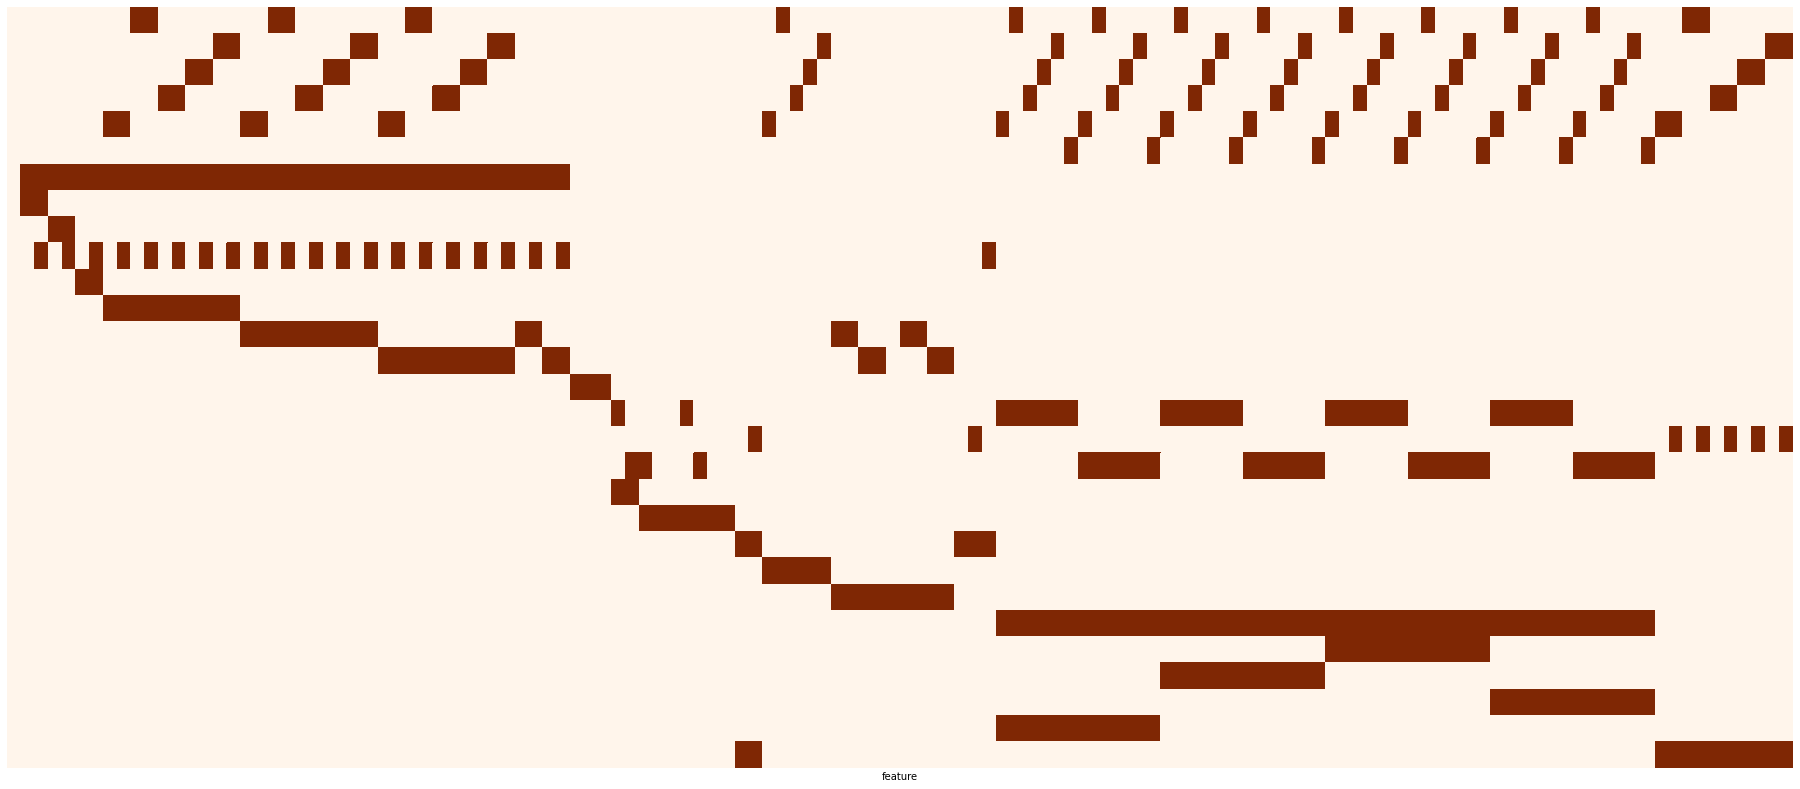

In [23]:
plt.figure(figsize=(32,14))
sns.heatmap(feature_tags.T,
            cbar=False,
            xticklabels=False,
            yticklabels=False,
            cmap="Oranges");

Let us sum the number of tags for each feature:

In [24]:
tag_sum = pd.DataFrame(feature_tags.T.sum(axis=0),columns=['Number of tags'])
tag_sum.T

feature         feature_0  feature_1  feature_2  feature_3  feature_4  \
Number of tags          0          2          3          2          3   

feature         feature_5  feature_6  feature_7  feature_8  feature_9  \
Number of tags          2          3          3          4          3   

feature         feature_10  feature_11  feature_12  feature_13  feature_14  \
Number of tags           4           3           4           3           4   

feature         feature_15  feature_16  feature_17  feature_18  feature_19  \
Number of tags           3           4           3           4           3   

feature         feature_20  feature_21  feature_22  feature_23  feature_24  \
Number of tags           4           3           4           3           4   

feature         feature_25  feature_26  feature_27  feature_28  feature_29  \
Number of tags           3           4           3           4           3   

feature         feature_30  feature_31  feature_32  feature_33  feature_34  \
Number of tags           4           3           4           3           4   

feature         feature_35  feature_36  feature_37  feature_38  feature_39  \
Number of tags           3           4           2           3           2   

feature         feature_40  feature_41  feature_42  feature_43  feature_44  \
Number of tags           3           1           1           1           2   

feature         feature_45  feature_46  feature_47  feature_48  feature_49  \
Number of tags           2           2           1           1           2   

feature         feature_50  feature_51  feature_52  feature_53  feature_54  \
Number of tags           2           1           1           2           3   

feature         feature_55  feature_56  feature_57  feature_58  feature_59  \
Number of tags           2           2           2           2           2   

feature         feature_60  feature_61  feature_62  feature_63  feature_64  \
Number of tags           2           2           2           2           1   

feature         feature_65  feature_66  feature_67  feature_68  feature_69  \
Number of tags           2           2           2           2           1   

feature         feature_70  feature_71  feature_72  feature_73  feature_74  \
Number of tags           2           2           4           4           4   

feature         feature_75  feature_76  feature_77  feature_78  feature_79  \
Number of tags           4           4           4           4           4   

feature         feature_80  feature_81  feature_82  feature_83  feature_84  \
Number of tags           4           4           4           4           4   

feature         feature_85  feature_86  feature_87  feature_88  feature_89  \
Number of tags           4           4           4           4           4   

feature         feature_90  feature_91  feature_92  feature_93  feature_94  \
Number of tags           4           4           4           4           4   

feature         feature_95  feature_96  feature_97  feature_98  feature_99  \
Number of tags           4           4           4           4           4   

feature         feature_100  feature_101  feature_102  feature_103  \
Number of tags            4            4            4            4   

feature         feature_104  feature_105  feature_106  feature_107  \
Number of tags            4            4            4            4   

feature         feature_108  feature_109  feature_110  feature_111  \
Number of tags            4            4            4            4   

feature         feature_112  feature_113  feature_114  feature_115  \
Number of tags            4            4            4            4   

feature         feature_116  feature_117  feature_118  feature_119  \
Number of tags            4            4            4            4   

feature         feature_120  feature_121  feature_122  feature_123  \
Number of tags            2            3            2            3   

feature         feature_124  featu

We can see that all of the features have at least one tag, and some as many a four. All except, that is, for `feature_0`, which has no tags at all.
There seem to be 5 (ish) regions that seem different to each other:

| '*Region*' | features | Tags | <font color="red">missing data?</font> | observations |
| :--- | :--- | :--- | :--- | :--- |
| 0 | feature_0 | none | none | -1 or +1 |
| 1  | 1...6 | **Tag 6** |  |
| 2  | 7-36  | **Tag 6** |  |
| 2a |  7..16 | + 11 | <font color="red">7, 8 and 11, 12</font> | |
| 2b | 17...26 | + 12 | <font color="red">17, 18 and 21, 22 </font>| |
| 2c | 27...36 | + 13 | <font color="red">27, 28 and 31, 32 </font>| |
| 3  | 37...72 | various | |
| 3a | 55...59 | Tag 21 | | All hybryd |
| 3b | 60...68 | Tag 22 | | All linear |
| 4  | 72-119 | **Tag 23** | |
| 4a | 72...77  |  + 15 & 27 | <font color="red"> 72 and 74</font> | |
| 4b | 78...83  |  + 17 & 27 |<font color="red"> 78 and 80</font>| |
| 4c | 84...89  |  + 15 & 25 | <font color="red"> 84 and 86</font>| |
| 4d | 90...95  |  + 17 & 25 | <font color="red"> 90 and 92</font>| |
| 4e | 96...101 |  + 15 & 24 | <font color="red"> 96 and 98</font>| |
| 4f | 102...107 | + 17 & 24 | <font color="red"> 102 and 104</font>| |
| 4g | 108...113 | + 15 & 26 | <font color="red"> 108 and 110</font>| |
| 4h | 114...119 | + 17 & 26 | <font color="red"> 114 and 116</font>| |
| 5  | 120...129 |**Tag 28** | |
| 5a | 120 |+ 4      | <font color="red">missing data</font> | |
| 5b | 121 |+ 4 & 16 |<font color="red">missing data</font> | |
| 5c | 122 |+ 0|| |
| 5d | 123 |+ 0 & 16|| |
| 5e | 124 |+ 3|| |
| 5f | 125 |+ 3 & 16|| |
| 5g | 126 |+ 2|| |
| 5h | 127 |+ 2 & 16|| |
| 5i | 128 |+ 1|| |
| 5j | 129 |+ 1 & 16|||


Here, more than anywhere, merits the classic: "*To be continued...*"

<a class="anchor" id="action"></a>
## <center style="background-color:Gainsboro; width:40%;">Action</center>

The target of this competition is the `action`: 1 to make the trade and 0 to pass on it. In view of this let us add a new 'binary' column to our test dataset called `action` such that if `resp` is positive then `action=1` else `action=0`

In [25]:
train_data['action'] = ((train_data['resp'])>0)*1

This is only a simple example for this EDA. I suspect that the actual formula that one uses to calculate the `action` will be critical in obtaining a good final score.

<a class="anchor" id="day_0"></a>
## <center style="background-color:Gainsboro; width:90%;">Now let us take a look at the first day ("day 0")</center>
To do this we shall make a new dataframe called `day_0`

In [26]:
day_0 = train_data.loc[train_data['date'] == 0]

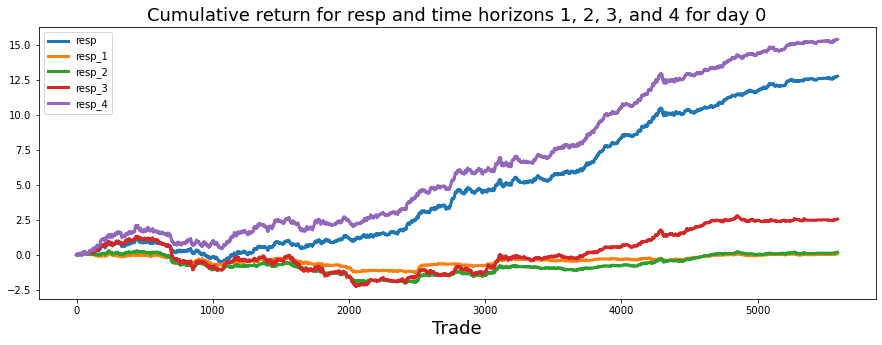

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))
balance= pd.Series(day_0['resp']).cumsum()
resp_1= pd.Series(day_0['resp_1']).cumsum()
resp_2= pd.Series(day_0['resp_2']).cumsum()
resp_3= pd.Series(day_0['resp_3']).cumsum()
resp_4= pd.Series(day_0['resp_4']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative return for resp and time horizons 1, 2, 3, and 4 for day 0", fontsize=18)
balance.plot(lw=3)
resp_1.plot(lw=3)
resp_2.plot(lw=3)
resp_3.plot(lw=3)
resp_4.plot(lw=3)
plt.legend(loc="upper left");

### <center style="background-color:Gainsboro; width:80%;">Descriptive statistics of the `train.csv` file for day 0</center>
Some simple [descriptive statistics](https://en.wikipedia.org/wiki/Descriptive_statistics) of the day 0 data:

In [28]:
day_0.describe().style.background_gradient(cmap=colorMap)

<a class="anchor" id="missing"></a>
## <center style="background-color:Gainsboro; width:60%;">Is there any missing data?</center>

To start with let us look at day 0 

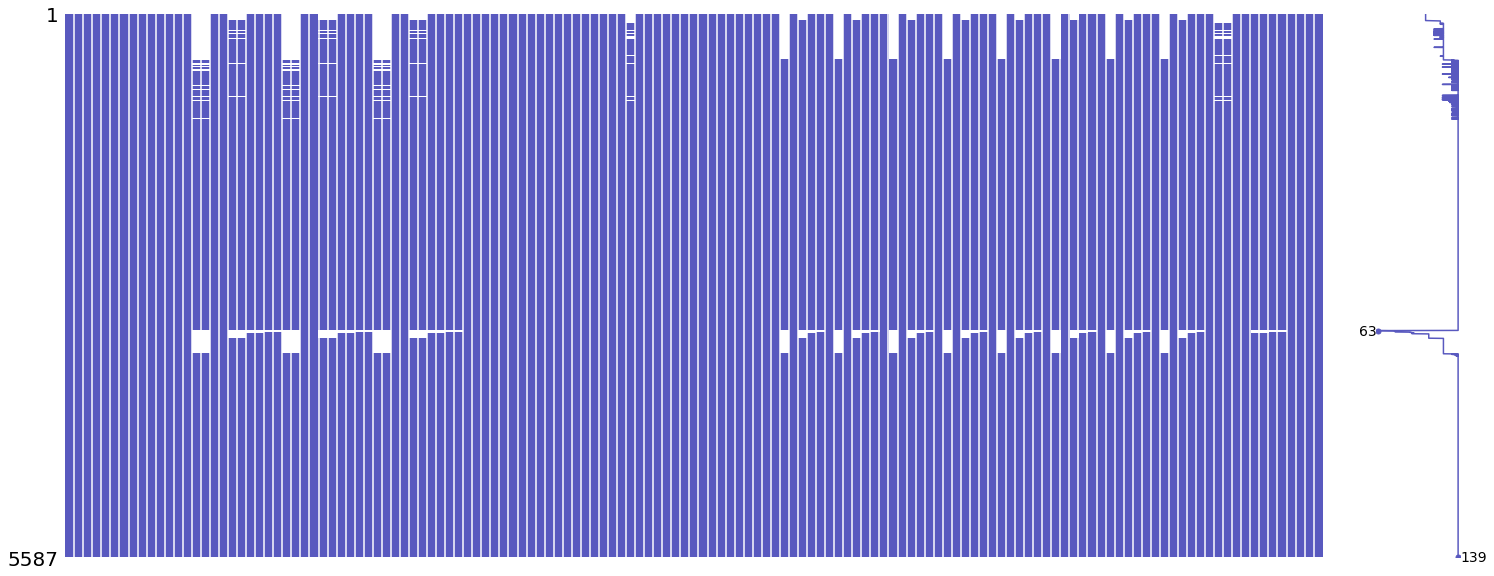

In [29]:
msno.matrix(day_0, color=(0.35, 0.35, 0.75));

graphically we can see that indeed there are chunks of missing data (in white) in some of the columns, and there appears to be a pattern. Let us take a look only at `feature_7` (the first `resp_1` feature) and `feature_11` (the first `resp_2` feature): 

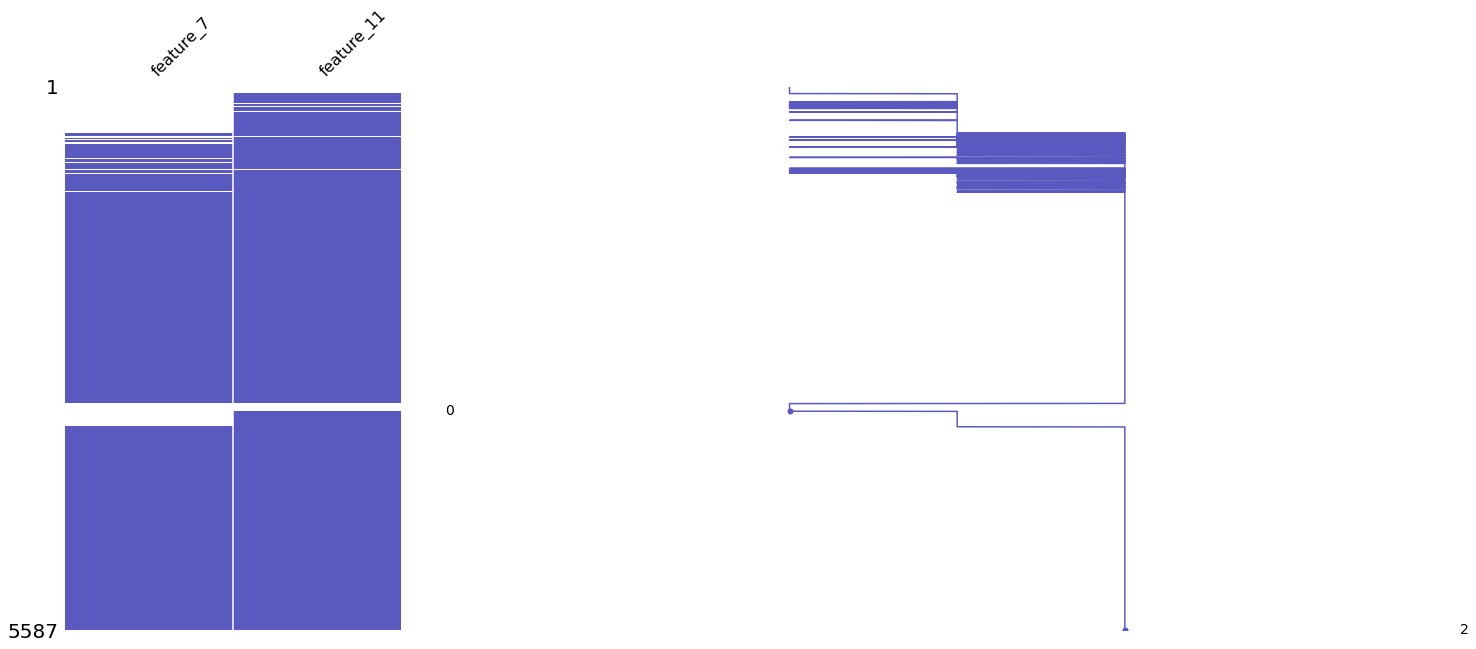

In [30]:
feats_7_11 = day_0.iloc[:, [14,18]]
msno.matrix(feats_7_11, color=(0.35, 0.35, 0.75), width_ratios=(1, 3));

we can see that the missing data does not appear to be random, indeed there appear to be two big chunks missing at the start and in the middle of each column. Let us assume that a [trading day](https://en.wikipedia.org/wiki/Trading_day) spans from 9:30 until 16:00. Let us also assume that the trades occur at regular intervals (which is almost certainly *not* the case) then `feature_7` has chunks of missing data from 9:30 until 10:03, and is missing ≈16 minutes from 13:17 until 13:33. `feature_11` has missing data from 9:30 until 9:35, and is missing ≈5½ minutes from 13:17 until 13:22.

Now let us look at the sum of the number of missing data in each column for the whole `train.csv` file:

In [31]:
#missing_data = pd.DataFrame(train_data.isna().sum().sort_values(ascending=False),columns=['Total missing'])
#missing_data.T

gone = train_data.isnull().sum()
px.bar(gone, color=gone.values, title="Total number of missing values for each column").show()

First of all, 

* **79.6%** of all the missing data is located in the **Tag 4** group, which represent the `resp_1` features
* **15.2%** of the missing data is in the **Tag 3** group, which represent the `resp_2` features
* In total, the features associated with `resp_1` and `resp_2` make up **> 95%** of all the missing data.

We can see that features 7 and 8 both have exactly the same number of missing values (393135). 
17 and 18, and 27 and 28 all have 395535 missing values each. These are all `resp_1` features.

Next we have features 72, 78, 84, 90, 96, 102, 108, 114 all with 351426 missing values each. These too are all `resp_1` features.

Features 21, 22, 31, 32 have 81444 missing values, closely followed by features 11 and 12. These are all `resp_2` features.

There are more features with even less missing values. I think the interesting thing is not so much the quantity of missing values in so much as it may tell us which features represent similar measures/metrics.

Is day 0 special, or does every day have missing data?

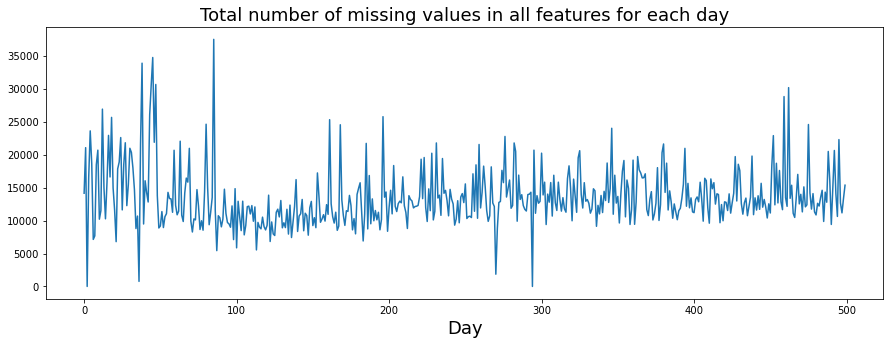

In [32]:
missing_features = train_data.iloc[:,7:137].isnull().sum(axis=1).groupby(train_data['date']).sum().to_frame()
# now make a plot
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(missing_features)
ax.set_xlabel ("Day", fontsize=18)
ax.set_title ("Total number of missing values in all features for each day", fontsize=18)
plt.show()

Indeed we can see that there is missing data *almost* every day, with no discernible pattern (weekly, monthly, *etc*). The exceptions are days **2** and **294**, where there are no missing values at all in the features. These two days could provide clues as to what, and even perhaps why, data is missing for the rest of the days. That said, these are two *very* quiet days; day 2 has 231 records, and day 294 has only 29.

In the notebook ["*Jane Street EDA Market Regime*"](https://www.kaggle.com/marketneutral/jane-street-eda-market-regime) written by [marketneutral](https://www.kaggle.com/marketneutral) a plot is made of the number of trades per day, and is strikingly similar to the above plot. In view of this, for curiosity, we shall plot the number of missing values in the features with respect to the number of trades, for each day.

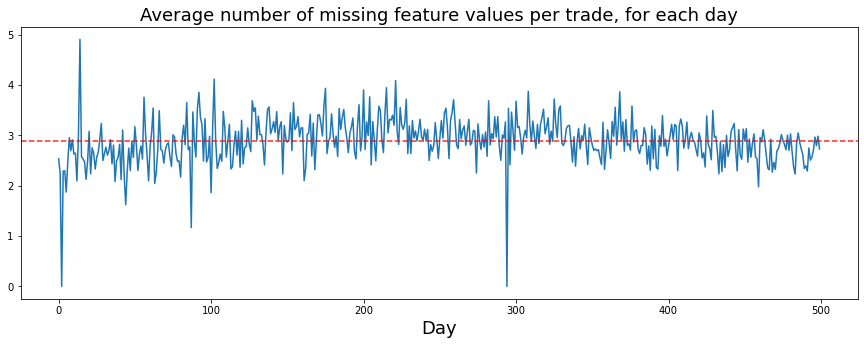

In [33]:
count_weights    = train_data[['date', 'weight']].groupby('date').agg(['count'])
result = pd.merge(count_weights, missing_features, on = "date", how = "inner")
result.columns = ['weights','missing']
result['ratio'] = result['missing']/result['weights']
missing_per_trade = result['ratio'].mean()

# now make a plot
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(result['ratio'])
plt.axhline(missing_per_trade, linestyle='--', alpha=0.85, c='r');
ax.set_xlabel ("Day", fontsize=18)
ax.set_title ("Average number of missing feature values per trade, for each day", fontsize=18)
plt.show()

We can see that on average there are $\approx$ 3 missing feature values per trade, per day, except for two spikes located on days 2 and 294 where there are no missing values at all. (The most missing values are on day 14).

This raises the question of [what to do with missing data in the unseen test data?](https://www.kaggle.com/c/jane-street-market-prediction/discussion/200691).
<a class="anchor" id="DABL"></a>
## <center style="background-color:Gainsboro; width:20%;">DABL plots</center>

Let us run **day 0** through the *data analysis baseline library* [dabl](https://github.com/amueller/dabl). First using the `action` as the target:

Target looks like classification
Showing only top 10 of 135 continuous features
Linear Discriminant Analysis training set score: 0.875


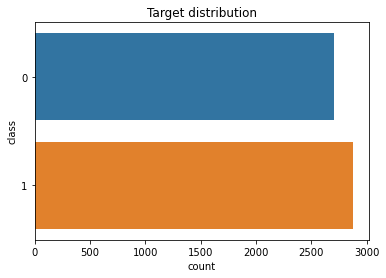

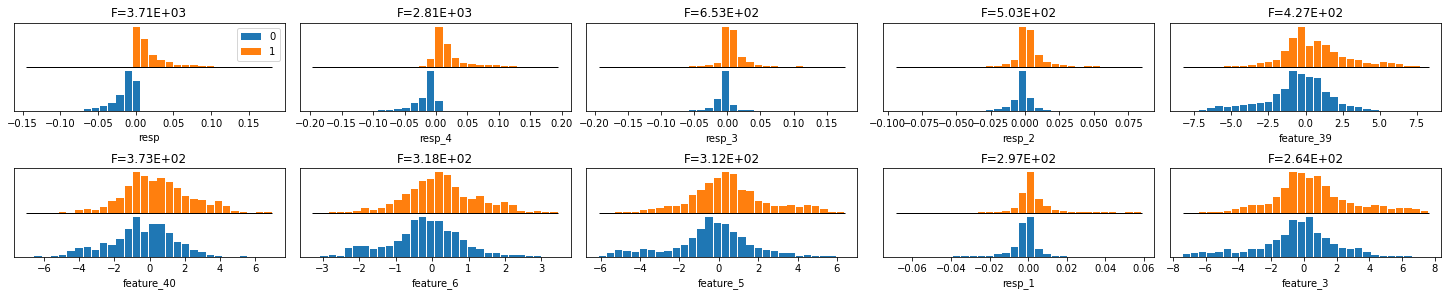

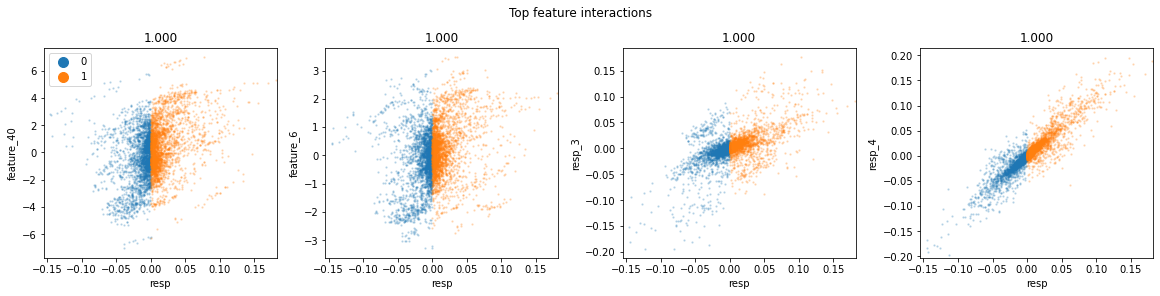

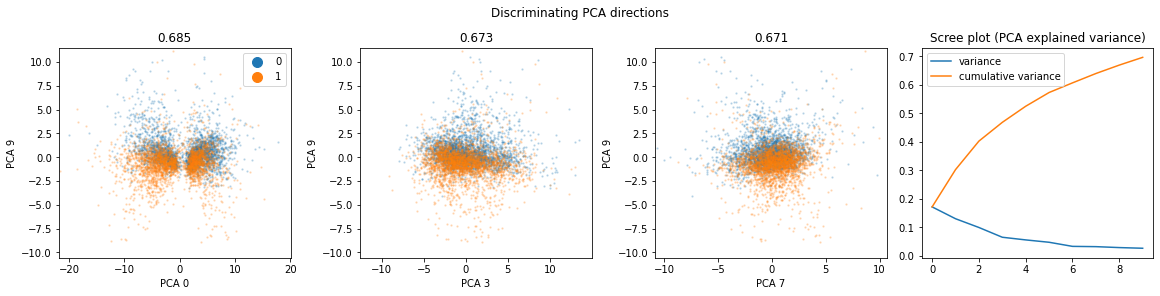

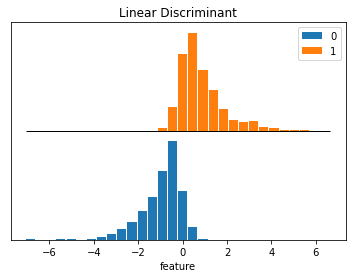

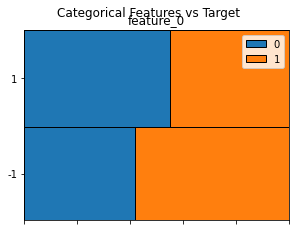

In [34]:
dabl.plot(day_0, target_col="action")

We can see that the classes 0 and 1 for `action` are reasonably well balanced.

Now we shall use `resp` as the target:

Target looks like regression
Showing only top 10 of 134 continuous features


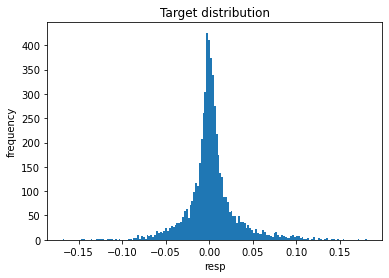

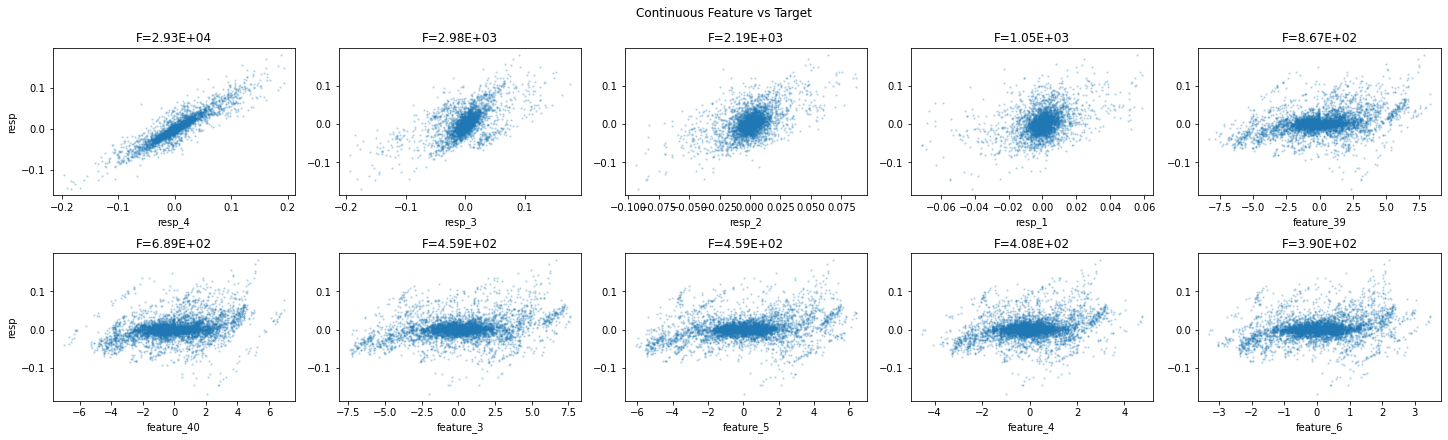

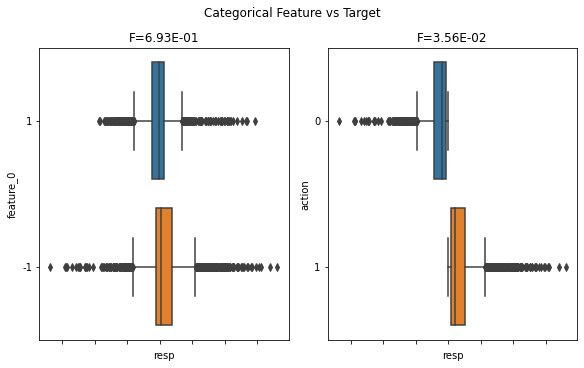

In [35]:
dabl.plot(day_0, target_col="resp")

### Plot the return (`resp`) with respect to time (`ts_id`) for day 0

In [36]:
fig_1 = px.scatter(day_0, x=day_0['ts_id'], y=day_0['resp'], 
                   trendline="ols", marginal_y="violin",
                   title=("Scatter plot of resp with respect to ts_id for day 0"))
fig_1.show()

<a class="anchor" id="permutation"></a>
## <center style="background-color:Gainsboro; width:100%;">Very quick Permutation Importance using the Random Forest</center>
We shall now perform a simple [permutation importance](https://www.kaggle.com/dansbecker/permutation-importance) calculation, a basic way of seeing which features may be important. We shall perform a regression, with `resp` as the target.

In [37]:
X_train = day_0.loc[:, day_0.columns.str.contains('feature')]
X_train = X_train.fillna(X_train.mean())
# our target is the action
y_train = day_0['resp']

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(max_features='auto')
regressor.fit(X_train, y_train)

RandomForestRegressor()

In [38]:
import eli5
from eli5.sklearn import PermutationImportance
perm_import = PermutationImportance(regressor, random_state=1).fit(X_train, y_train)
# visualize the results
eli5.show_weights(perm_import, top=15, feature_names = X_train.columns.tolist())

We can see in this very simple example that for the first day (**day 0**) the top 5 most important features appear to be 39, 43, 37, 5 and 42.

Note:

> Features that are deemed of low importance for a bad model (low cross-validation score) could be very important for a good model. Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances. Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for a particular model. (Source: [scikit-learn permutation importance](https://scikit-learn.org/stable/modules/permutation_importance.html)).

It goes without saying that a serious study of the feature importance is essential (and will use *a lot* of CPU). For a much more advanced approach may I suggest taking a look at ["Feature selection using the Boruta-SHAP package"](https://www.kaggle.com/carlmcbrideellis/feature-selection-using-the-boruta-shap-package).

<a class="anchor" id="Pearson"></a>
## <center style="background-color:Gainsboro; width:80%;">Is there any correlation between day 2 and day 294?</center>
Are the days independent? For the moment let us take a look at day(2) and day(294) using a [Pearson pairwise correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) matrix (this is a **big** matrix!). Why days 2 and 294? Because they appear to be the *only* two days in `train.csv` for which there are no missing values at all. Also, they are far apart in time, thus reducing any temporal leakage.
We shall use a [diverging colormap](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html) where red indicates positive linear correlation, and blue indicates linear anti-correlation:

In [39]:
day_2   = train_data.loc[train_data['date'] == 2]
day_294 = train_data.loc[train_data['date'] == 294]
day_2_and_294 = pd.concat([day_2, day_294])
day_2_and_294.corr(method='pearson').style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

We can see a correlation of 0.64 between our simple definition of `action` and the value of `resp`.

It has been mentioned that the [Spearman's rank correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) is more apropo for financial data. One can simply change `method='pearson'` to `method='spearman'` in the [pandas.DataFrame.corr](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) to see such correlations.

Navigating around there do appear to be some rather curious regions, for example between features 120 through to 129:

In [40]:
subset = day_2_and_294[["feature_120","feature_121","feature_122","feature_123","feature_124","feature_125","feature_126","feature_127","feature_128","feature_129"]]
subset.corr(method='pearson').style.background_gradient(cmap='coolwarm', low=1, high=0, axis=None).set_precision(2)

...not sure what this means at the moment! 

We shall now find the pairs of features with a correlation > |0.992|:

In [41]:
features_day_2     = day_2.iloc[:,7:137]
features_day_294   = day_294.iloc[:,7:137]
features_2_and_294 = pd.concat([features_day_2, features_day_294])

# code from: https://izziswift.com/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas/
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

corrFilter(features_2_and_294, .992).to_frame()

0
feature_65  feature_61  -0.993421
feature_61  feature_66  -0.992336
feature_60  feature_65  -0.992019
feature_95  feature_119  0.996355
feature_107 feature_119  0.996550
feature_66  feature_65   0.998174
feature_61  feature_60   0.999343
feature_63  feature_62   0.999801
feature_67  feature_68   0.999958
feature_0   feature_0         NaN

It looks like we can certainly cut down on the number of eventual features in our model. A good place to start will be to look at the features in the region of the **60's** (*i.e.* **Tag 22**) as there seems to be a lot of auto-correlation there.

<a class="anchor" id="test_data"></a>
# <center style="background-color:Gainsboro; width:40%;">The test data</center>
The wall time taken for a submission to return a score in this competition is around 3½ hours, so testing a script before submitting is (as always) *very* important. We are provided with some test data in the smaller (36 MB) file `example_test.csv`. This file contains over 15k rows, and covers 3 days of data. It consists of the 130 `features` as in the `train.csv`, as well as the `weight` for each trade. It is interesting to note that `example_test.csv` contains no `resp` data.

<a class="anchor" id="evaluation"></a>
# <center style="background-color:Gainsboro; width:40%;">Evaluation</center>
This competition is evaluated via a utility score $(u)$. For a detailed description of this score see the excellent notebook ["*Understanding the Utility Score Function*"](https://www.kaggle.com/renataghisloti/understanding-the-utility-score-function) written by [Renata Ghisloti Duarte de Souza](https://www.kaggle.com/renataghisloti).

When it comes to 'off-line' evaluation with cross-validation may I also suggest the notebook ["*Found the Holy Grail: GroupTimeSeriesSplit*"](https://www.kaggle.com/jorijnsmit/found-the-holy-grail-grouptimeseriessplit) written by [Jorijn Jacko Smit](https://www.kaggle.com/jorijnsmit).

### <center style="background-color:LightGreen; width:40%;">Thank you for your time!</center>